#Introducción
---
TFM: Aplicación de ciencia de datos en el sector de producción animal para la predicción y explicación de óptimos en ganado porcino.

*Titulo*: **Regresión RandomForest**

*Autor*: **Jose Eduardo Cámara Gómez**

---


# Preparación y selección de variables para modelos

## Importar paquetes

In [1]:
# Importación de paquetes
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
from matplotlib.pyplot import figure

from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

sns.set(style="darkgrid")

In [2]:
from google.colab import files
# Cargamos el fichero del dataset gmd_02.csv
uploaded = files.upload()

Saving gmd_02.csv to gmd_02.csv


In [3]:
# Leemos el fichero csv con los datos
df = pd.read_csv('gmd_02.csv', sep=';')

## Agrupar razas similares, para reducir categorías

In [4]:
# Revisar la raza si se agrupan las razas con menos ocurrencias
agrupar_razas = {93 : 93, 85 : 93, 90 : 93, 95 : 93, 94 : 93, 82 : 93, 80 : 80, 96 : 80, 88 : 88, 0 : 0, 23 : 0, 84 : 0, 66 : 0, 18 : 0, 68 : 88, 7 : 7, 89 : 7, 65 : 7, 15 : 15, 97 : 7, 69 : 69, 81 : 81}
df.replace({'ct_raza' : agrupar_razas}, inplace=True)

## Convertir tipos de variables Categóricas y Fecha

In [5]:
# Convertimos los tipos
df["ct_integra"] = df["ct_integra"].astype("category")
#df["ct_tipo"] = df["ct_tipo"].astype("category")
df["ct_raza"] = df["ct_raza"].astype("category")
df["ct_fase"] = df["ct_fase"].astype("category")
df['EntradaInicial']= pd.to_datetime(df['EntradaInicial'])
df['EntradaFinal']= pd.to_datetime(df['EntradaFinal'])
df["na_rega"] = df["na_rega"].astype("category")
df["NumBajas"] = df["NumBajas"].astype("int64")
df["gr_codpos"] = df["gr_codpos"].astype("category")
df["gr_poblacion"] = df["gr_poblacion"].astype("category")
df["na_nombre2"] = df["na_nombre2"].astype("category")


## Convertir variables categóricas a usar en OneHotEncoding

In [6]:
# Funcion para convertir en One Hot Encoding
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res)

## Seleccionar Variables a Utilizar

In [7]:
# Cargamos las variables objetivo y las usadas
y = df['GMD']
x0 = df[['ct_integra','ct_tipo', 'ct_raza', 'IncPeso', 'DiasMedios', 'NumAnimales', 
         'na_rega', 'PesoEntMedio', 'PesoRecMedio', 'NumBajas', 'GPS_Longitud', 'GPS_Latitud', 
         'semanaEntrada', 'añoEntrada', 'PorcHembras', 'PiensoCerdaDia']]
features_to_encode = ['ct_raza']   # , 'na_rega']
x1 = x0.copy()
x1.drop(['ct_integra','na_rega'], inplace=True, axis=1)
for feature in features_to_encode:
    x1 = encode_and_bind(x1, feature)


## Comprobar si hay variables dependientes

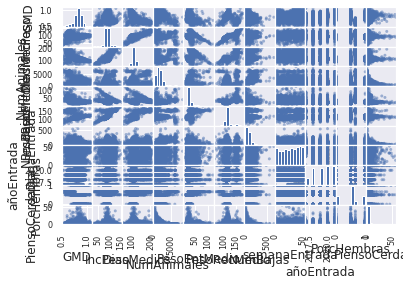

In [10]:
attributes = ['GMD', 'IncPeso', 'DiasMedios', 'NumAnimales', 'PesoEntMedio', 'PesoRecMedio', 'NumBajas', 'semanaEntrada', 'añoEntrada', 'PorcHembras', 'PiensoCerdaDia']
pd.plotting.scatter_matrix(df[attributes])
plt.show()


## Dividir datos en entrenamiento y test

In [11]:
X_train, X_test, y_train, y_test = train_test_split(x1, y, test_size = 0.2, random_state = 123)

## Escalar datos

In [12]:
## Vemos de escalar las variables para que no se vean influenciadas por la escala.
scaler = RobustScaler()
scaler.fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

# Modelo RandomForest

## Creación del modelo

In [13]:
rf = RandomForestRegressor(
            n_estimators = 100,
            criterion    = 'squared_error',
            max_depth    = None,
            max_features = 'sqrt',
            oob_score    = False,
            n_jobs       = -1,
            random_state = 123
         )
rf.fit(X_train_s, y_train)

RandomForestRegressor(max_features='sqrt', n_jobs=-1, random_state=123)

## Ver diferencias entre valor real y predicho en Test

In [14]:
# Función para Graficar diferencias entre valor predicho y real en datos de test del modelo pasado
def graficoDiferencias(modelo, X_test_s, y_test):
    y_pred = modelo.predict(X_test_s)
    diferencia = abs(y_pred - y_test)
    g = sns.jointplot(x=y_test, y=y_pred)
    # Draw a line of x=y
    x0, x1 = g.ax_joint.get_xlim()
    y0, y1 = g.ax_joint.get_ylim()
    lims = [max(x0, y0), min(x1, y1)]
    g.ax_joint.plot(lims, lims, '-r')
    g.ax_joint.scatter(x=y_test, y=y_pred, c=diferencia.values, cmap=sns.dark_palette("#69d", reverse=True, as_cmap=True))
    plt.show()

Score R2: 0.940290778143984


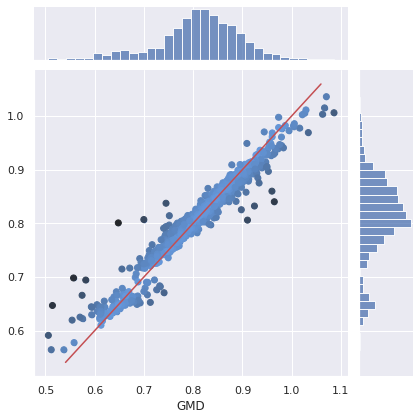

In [15]:
# Graficar las diferencias
print('Score R2:',rf.score(X_test_s, y_test))
graficoDiferencias(rf, X_test_s, y_test)

## Variables más importantes según modelo

In [17]:
# Mostrar las variables más importantes
important_features_dict = {}
for idx, val in enumerate(rf.feature_importances_):
    important_features_dict[idx] = val

important_features_list = sorted(important_features_dict, key=important_features_dict.get, reverse=True)
print(f'Las 10 características más relevantes pera la regresión son:')
print('\tOrden\tCaracterística\tImportancia')
for i in range(10):
    print('\t', i+1, '\t', x1.columns[important_features_list[i]], '\t', important_features_dict.get(important_features_list[i]))

Las 10 características más relevantes pera la regresión son:
	Orden	Característica	Importancia
	 1 	 DiasMedios 	 0.22358858036505885
	 2 	 PesoRecMedio 	 0.19182689712015655
	 3 	 ct_tipo 	 0.10991871793945555
	 4 	 IncPeso 	 0.09861245219426418
	 5 	 ct_raza_69 	 0.08238517408447579
	 6 	 PesoEntMedio 	 0.05983066533737301
	 7 	 PorcHembras 	 0.04372304675143815
	 8 	 semanaEntrada 	 0.03822699150339668
	 9 	 ct_raza_93 	 0.032548017460435646
	 10 	 NumAnimales 	 0.023499950337882443


## Optimización de Hiperparámetros
Intenteamos ver hasta dónde se pueden optimizar los hiperparámetros haciendo uso de una búsqueda aleatoria entre una gran variadead de valores de esos hiperparámetros.

### Definir hiperparámetros a optimizar y con qué posibles valores

In [18]:
# Hago una optimización de los hiperparámetros para RandomForest
from sklearn.model_selection import RandomizedSearchCV
random_grid = {'bootstrap': [True, False],
               'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
               'max_features': [1.0, 'sqrt', 2, 5, 10, 20],
               'min_samples_leaf': [1, 2, 4, 10],
               'min_samples_split': [2, 5, 10, 20],
               'n_estimators': [20, 50, 75, 100, 150, 250, 500]}


### Lanzar búsqueda de mejores parámetros

In [19]:
rf_random = RandomizedSearchCV(scoring="neg_mean_squared_error", estimator = rf, param_distributions = random_grid, n_iter = 300, cv = 3, verbose=1, random_state=123, n_jobs = -1)
rf_random.fit(X_train_s, y_train)

Fitting 3 folds for each of 300 candidates, totalling 900 fits


RandomizedSearchCV(cv=3,
                   estimator=RandomForestRegressor(max_features='sqrt',
                                                   n_jobs=-1,
                                                   random_state=123),
                   n_iter=300, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': [1.0, 'sqrt', 2, 5, 10,
                                                         20],
                                        'min_samples_leaf': [1, 2, 4, 10],
                                        'min_samples_split': [2, 5, 10, 20],
                                        'n_estimators': [20, 50, 75, 100, 150,
                                                         250, 500]},
                   random_state=123, scoring='neg_mean_squared_error',
                   verbose=1)

### Analizar mejor modelo y su error

In [20]:
rf_random.best_params_

{'n_estimators': 150,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 1.0,
 'max_depth': None,
 'bootstrap': True}

Tras probar aleatoreamente entre 300 combinaciones del rango de hiperparámetros propuesto la mejor solución para optimizar el error cuadrático medio ha sido la que se muestra. La búsqueda de los mejores hiperparámetros tardó en Google Colab 26 minutos, probando las 300 combinaciones para 3 particiones de los datos cada una.

In [21]:
print('Score R2:',rf_random.best_score_)

Score R2: -0.00021213044110303427


El error obtenido es de tan sólo -0.00021213...

Score R2: 0.9713325517392077


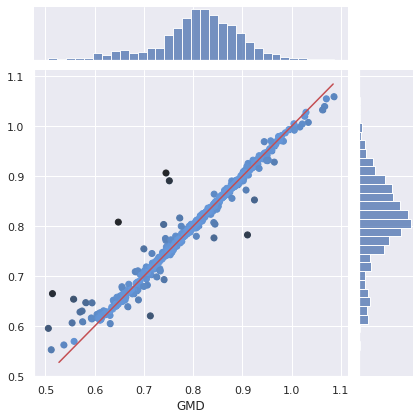

In [22]:
print('Score R2:',rf_random.best_estimator_.score(X_test_s, y_test))
graficoDiferencias(rf_random.best_estimator_, X_test_s, y_test)

Hemos obtenido un coeficiente de determinación de 97,13%, mejorando el de los parámetros iniciales en un 3%.

In [23]:
# Medimos las diferencias de la predicción según RMSE
from sklearn.metrics import mean_squared_error
y_pred_rf_01 = rf_random.best_estimator_.predict(X_test_s)
print('Error cuadrático medio:',mean_squared_error(y_test, y_pred_rf_01))

Error cuadrático medio: 0.000205420873220814


Si medimos las diferencias sobre el conjunto de datos de test (no usado en el entrenamiento), el error se mantiene similar al obtenido en la validación cruzada del modelo, por lo que parece que no está sobreajustado y generaliza correctamente.

# Estimar mejores modelos con LazzyPredict
La librería lazzypredict permite estimar los modelos que mejor representan nuestro modelo según una métrica dada, probando en más de 40 modelos y ofreciendo un ranking de los resultados. No ofrecen los mejores hiperparámetros para cada uno de esos modelos, pero es un buen punto de partida, para seleccionar los modelos más prometedores y realizar sobre ellos la optimización de hiperparámetros, con la que encontrar más rápidamente un buen modelo que se aproxime a la mejor solución disponible con los métodos y variables actuales.

In [24]:
!pip install lazypredict

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [25]:
import lazypredict
from lazypredict.Supervised import LazyRegressor
# Borramos el modelo que tarda mucho
del lazypredict.Supervised.REGRESSORS[29:32]    # PassiveAggressiveRegressor, PoissonRegressor, QuantileRegressor
reg = LazyRegressor(verbose=1, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_train_s, X_test_s, y_train, y_test)

print(models)

  3%|▎         | 1/39 [00:01<00:41,  1.10s/it]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.8458836069304074, 'Adjusted R-Squared': 0.8427535834734815, 'RMSE': 0.03323167140917606, 'Time taken': 1.101137399673462}


  5%|▌         | 2/39 [00:01<00:30,  1.20it/s]

{'Model': 'BaggingRegressor', 'R-Squared': 0.9688202021636585, 'Adjusted R-Squared': 0.9681869567530558, 'RMSE': 0.014947357243164252, 'Time taken': 0.6370360851287842}
{'Model': 'BayesianRidge', 'R-Squared': 0.9742048575206925, 'Adjusted R-Squared': 0.9736809716482888, 'RMSE': 0.013595548464256514, 'Time taken': 0.09035086631774902}


 15%|█▌        | 6/39 [00:02<00:07,  4.14it/s]

{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.9273593104184895, 'Adjusted R-Squared': 0.9258840159492325, 'RMSE': 0.022814856735196013, 'Time taken': 0.20186495780944824}
{'Model': 'DummyRegressor', 'R-Squared': -0.00023142543513321456, 'Adjusted R-Squared': -0.02054560332114641, 'RMSE': 0.08465995131903602, 'Time taken': 0.05101585388183594}
{'Model': 'ElasticNet', 'R-Squared': -0.00023142543513321456, 'Adjusted R-Squared': -0.02054560332114641, 'RMSE': 0.08465995131903602, 'Time taken': 0.06140899658203125}


 21%|██        | 8/39 [00:02<00:08,  3.82it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.9740553524906352, 'Adjusted R-Squared': 0.9735284302491491, 'RMSE': 0.013634890487995665, 'Time taken': 0.5051455497741699}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.8746187716296872, 'Adjusted R-Squared': 0.8720723443610444, 'RMSE': 0.02997395334609587, 'Time taken': 0.1257338523864746}


 23%|██▎       | 9/39 [00:07<00:47,  1.60s/it]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9719630985396149, 'Adjusted R-Squared': 0.97139368371305, 'RMSE': 0.01417401129332647, 'Time taken': 5.118066787719727}


 26%|██▌       | 10/39 [00:08<00:35,  1.21s/it]

{'Model': 'GammaRegressor', 'R-Squared': 0.6734150642236648, 'Adjusted R-Squared': 0.6667822947349772, 'RMSE': 0.048375541679610515, 'Time taken': 0.23118114471435547}


 28%|██▊       | 11/39 [00:16<01:31,  3.28s/it]

{'Model': 'GaussianProcessRegressor', 'R-Squared': -5.57309765495273, 'Adjusted R-Squared': -5.706593835565889, 'RMSE': 0.2170265212517378, 'Time taken': 8.424036741256714}


 31%|███       | 12/39 [00:20<01:32,  3.42s/it]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.972036976722979, 'Adjusted R-Squared': 0.9714690623237358, 'RMSE': 0.014155324475594309, 'Time taken': 3.743919849395752}


 33%|███▎      | 13/39 [00:28<02:02,  4.70s/it]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.981825078527157, 'Adjusted R-Squared': 0.9814559553637819, 'RMSE': 0.011412059791059555, 'Time taken': 7.777765989303589}


 38%|███▊      | 15/39 [00:28<00:58,  2.44s/it]

{'Model': 'HuberRegressor', 'R-Squared': 0.9636794677360618, 'Adjusted R-Squared': 0.962941816693951, 'RMSE': 0.01613258154452639, 'Time taken': 0.3591623306274414}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.8344913942791174, 'Adjusted R-Squared': 0.8311300009327552, 'RMSE': 0.034438010719842656, 'Time taken': 0.12135577201843262}


 49%|████▊     | 19/39 [00:30<00:20,  1.01s/it]

{'Model': 'KernelRidge', 'R-Squared': -91.11648214077539, 'Adjusted R-Squared': -92.9873197858008, 'RMSE': 0.8124496182403466, 'Time taken': 1.7480552196502686}
{'Model': 'Lars', 'R-Squared': -2.0330061718880246, 'Adjusted R-Squared': -2.0946049432706633, 'RMSE': 0.14742271797695453, 'Time taken': 0.02900218963623047}
{'Model': 'LarsCV', 'R-Squared': 0.9076660601509716, 'Adjusted R-Squared': 0.9057908060534575, 'RMSE': 0.025722220117985833, 'Time taken': 0.0649571418762207}
{'Model': 'Lasso', 'R-Squared': -0.00023142543513321456, 'Adjusted R-Squared': -0.02054560332114641, 'RMSE': 0.08465995131903602, 'Time taken': 0.02730250358581543}


 51%|█████▏    | 20/39 [00:30<00:16,  1.16it/s]

{'Model': 'LassoCV', 'R-Squared': 0.9740587629894424, 'Adjusted R-Squared': 0.9735319100134059, 'RMSE': 0.013633994285686, 'Time taken': 0.32060670852661133}
{'Model': 'LassoLars', 'R-Squared': -0.00023142543513321456, 'Adjusted R-Squared': -0.02054560332114641, 'RMSE': 0.08465995131903602, 'Time taken': 0.062177181243896484}


 59%|█████▉    | 23/39 [00:31<00:07,  2.08it/s]

{'Model': 'LassoLarsCV', 'R-Squared': 0.9740112137605343, 'Adjusted R-Squared': 0.973483395084491, 'RMSE': 0.013646483842689348, 'Time taken': 0.14906907081604004}
{'Model': 'LassoLarsIC', 'R-Squared': 0.9742017897797559, 'Adjusted R-Squared': 0.9736778416031359, 'RMSE': 0.013596356879651881, 'Time taken': 0.09488821029663086}
{'Model': 'LinearRegression', 'R-Squared': 0.9742411130044903, 'Adjusted R-Squared': 0.9737179634620283, 'RMSE': 0.013585990724681639, 'Time taken': 0.07036733627319336}


 64%|██████▍   | 25/39 [00:31<00:06,  2.21it/s]

{'Model': 'LinearSVR', 'R-Squared': 0.9578444971278379, 'Adjusted R-Squared': 0.9569883408799507, 'RMSE': 0.01738020537423998, 'Time taken': 0.734478235244751}


 67%|██████▋   | 26/39 [00:34<00:10,  1.26it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.6681183563598421, 'Adjusted R-Squared': 0.6613780135006126, 'RMSE': 0.048766252495305806, 'Time taken': 2.040773630142212}


 77%|███████▋  | 30/39 [00:54<00:24,  2.68s/it]

{'Model': 'NuSVR', 'R-Squared': 0.992111762521968, 'Adjusted R-Squared': 0.9919515565383716, 'RMSE': 0.007518267176847674, 'Time taken': 20.1945161819458}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.5294344783992626, 'Adjusted R-Squared': 0.5198775384054373, 'RMSE': 0.05806812705734184, 'Time taken': 0.021038055419921875}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.9725173824111705, 'Adjusted R-Squared': 0.9719592248005656, 'RMSE': 0.01403320321413072, 'Time taken': 0.03635835647583008}
{'Model': 'RANSACRegressor', 'R-Squared': -9.594686330328755e+23, 'Adjusted R-Squared': -9.789549398933111e+23, 'RMSE': 82916919220.0113, 'Time taken': 0.0745241641998291}


 85%|████████▍ | 33/39 [00:58<00:11,  1.94s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9712938339505025, 'Adjusted R-Squared': 0.970710826709652, 'RMSE': 0.014342186420013902, 'Time taken': 4.23161768913269}
{'Model': 'Ridge', 'R-Squared': 0.9742177023214985, 'Adjusted R-Squared': 0.973694077320291, 'RMSE': 0.013592163062196278, 'Time taken': 0.034204721450805664}
{'Model': 'RidgeCV', 'R-Squared': 0.9742177023214325, 'Adjusted R-Squared': 0.9736940773202236, 'RMSE': 0.013592163062213697, 'Time taken': 0.07680463790893555}


 90%|████████▉ | 35/39 [00:59<00:05,  1.26s/it]

{'Model': 'SGDRegressor', 'R-Squared': 0.9734482275535332, 'Adjusted R-Squared': 0.9729089749216417, 'RMSE': 0.01379350147151564, 'Time taken': 0.14826726913452148}
{'Model': 'SVR', 'R-Squared': 0.7458962500333934, 'Adjusted R-Squared': 0.7407355355756577, 'RMSE': 0.04267104747950279, 'Time taken': 0.11995244026184082}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.9742411130044903, 'Adjusted R-Squared': 0.9737179634620283, 'RMSE': 0.013585990724681639, 'Time taken': 0.035103559494018555}


 95%|█████████▍| 37/39 [00:59<00:01,  1.26it/s]

{'Model': 'TweedieRegressor', 'R-Squared': 0.6717526689455553, 'Adjusted R-Squared': 0.6650861370769448, 'RMSE': 0.04849850692475896, 'Time taken': 0.10561156272888184}


 97%|█████████▋| 38/39 [01:00<00:00,  1.00it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.9782149217694852, 'Adjusted R-Squared': 0.9777724782077436, 'RMSE': 0.01249416763908804, 'Time taken': 1.703658103942871}


100%|██████████| 39/39 [01:01<00:00,  1.57s/it]

{'Model': 'LGBMRegressor', 'R-Squared': 0.981449205860935, 'Adjusted R-Squared': 0.9810724489200062, 'RMSE': 0.011529461404855711, 'Time taken': 0.29209017753601074}
                                        Adjusted R-Squared  \
Model                                                        
NuSVR                                                 0.99   
HistGradientBoostingRegressor                         0.98   
LGBMRegressor                                         0.98   
XGBRegressor                                          0.98   
TransformedTargetRegressor                            0.97   
LinearRegression                                      0.97   
Ridge                                                 0.97   
RidgeCV                                               0.97   
BayesianRidge                                         0.97   
LassoLarsIC                                           0.97   
LassoCV                                               0.97   
ElasticNetCV                